In [ ]:
# Set config & resolve the role

In [1]:
import sagemaker, boto3, os
from sagemaker import Session

REGION = "us-east-1"
BUCKET = "udacity-fraud-capstone"
PREFIX = "fraud"

sess = sagemaker.Session()
boto3.setup_default_session(region_name=REGION)

# UdacityCapstone-SageMaker-ExecutionRole
try:
    ROLE = sagemaker.get_execution_role()
except Exception:
    ROLE = "arn:aws:iam::911167919655:role/UdacityCapstone-SageMaker-ExecutionRole"

print("Region:", REGION)
print("Bucket:", BUCKET)
print("Prefix:", PREFIX)
print("Role:", ROLE)



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-east-1
Bucket: udacity-fraud-capstone
Prefix: fraud
Role: arn:aws:iam::911167919655:role/service-role/AmazonSageMaker-ExecutionRole-20250821T124557


In [3]:
#Upload the code/ directory to S3
from sagemaker.s3 import S3Uploader

s3_code_path = S3Uploader.upload("../code", f"s3://{BUCKET}/{PREFIX}/code")
print("Code uploaded to:", s3_code_path)


Code uploaded to: s3://udacity-fraud-capstone/fraud/code


In [8]:
# Define training channels pointing to processed splits
from sagemaker.inputs import TrainingInput

channels = {
    "train": TrainingInput(f"s3://{BUCKET}/{PREFIX}/data/processed/train.csv", content_type="text/csv"),
    "val":   TrainingInput(f"s3://{BUCKET}/{PREFIX}/data/processed/val.csv",   content_type="text/csv"),
}




In [9]:
# Create the SKLearn estimator (baseline Logistic Regression)

from sagemaker.sklearn.estimator import SKLearn

output_path = f"s3://{BUCKET}/{PREFIX}/artifacts/"

est = SKLearn(
    entry_point="train.py",
    source_dir="../code",          # <— local path from notebooks/ to code/
    role=ROLE,
    instance_type="ml.m5.large",
    instance_count=1,
    framework_version="1.2-1",
    py_version="py3",
    output_path=output_path,
    disable_profiler=True
)

est



In [10]:
est.fit(channels)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2025-08-21-08-36-44-374


2025-08-21 08:36:46 Starting - Starting the training job...
2025-08-21 08:37:01 Starting - Preparing the instances for training...
2025-08-21 08:37:22 Downloading - Downloading input data...
2025-08-21 08:37:52 Downloading - Downloading the training image...
2025-08-21 08:38:48 Training - Training image download completed. Training in progress../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-08-21 08:38:52,868 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-08-21 08:38:52,872 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-08-21 08:38:52,875 sagemaker-training-toolkit INFO     No Neurons detected (normal if no n

In [13]:
#Sanity-run a single XGBoost training job (no tuner)
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.image_uris import retrieve
from sagemaker.inputs import TrainingInput

ROLE   = "arn:aws:iam::911167919655:role/UdacityCapstone-SageMaker-ExecutionRole"
REGION = "us-east-1"
BUCKET = "udacity-fraud-capstone"
PREFIX = "fraud"

session = sagemaker.Session()
container = retrieve("xgboost", REGION, version="1.7-1")  # stable

xgb = Estimator(
    image_uri=container,
    role=ROLE,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{BUCKET}/{PREFIX}/outputs/",
    hyperparameters={
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "verbosity": 1,
        "num_round": 400,              # REQUIRED
        "early_stopping_rounds": 20,
        "scale_pos_weight": 577        # imbalance ratio approx
    },
    sagemaker_session=session,
)

train_in = TrainingInput(f"s3://{BUCKET}/{PREFIX}/data/processed_xgb/train.csv", content_type="text/csv")
val_in   = TrainingInput(f"s3://{BUCKET}/{PREFIX}/data/processed_xgb/val.csv",   content_type="text/csv")

xgb.fit({"train": train_in, "validation": val_in})


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-08-21-09-51-11-351


2025-08-21 09:51:11 Starting - Starting the training job...
2025-08-21 09:51:44 Starting - Preparing the instances for training...
2025-08-21 09:52:05 Downloading - Downloading input data......
2025-08-21 09:52:55 Downloading - Downloading the training image......
2025-08-21 09:53:56 Training - Training image download completed. Training in progress../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-08-21 09:53:59.420 ip-10-2-229-220.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-08-21 09:53:59.495 ip-10-2-229-220.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-08-21:09:53:59:INFO] Imported framework sagemaker_xgboost_container.tr

In [14]:
!python ../code/hpo.py

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
....................................................................................................................................................!
Launched HPO job.


In [16]:
#Pick the latest tuning job and (optionally) wait until it’s Completed
import boto3, time
REGION = "us-east-1"
sm = boto3.client("sagemaker", region_name=REGION)

# Get the most recent tuning job
resp = sm.list_hyper_parameter_tuning_jobs(SortBy="CreationTime", SortOrder="Descending")
tuning_name = resp["HyperParameterTuningJobSummaries"][0]["HyperParameterTuningJobName"]
print("Latest tuning job:", tuning_name)

# Optional: wait for completion (prints status every 30s)
while True:
    desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_name)
    status = desc["HyperParameterTuningJobStatus"]
    print("Status:", status)
    if status in ("Completed", "Failed", "Stopped"):
        break
    time.sleep(30)

# Keep the full desc for next cell
tuning_desc = desc


Latest tuning job: sagemaker-xgboost-250821-1000
Status: Completed


In [17]:
#Get the best training job → fetch artifact & tuned params
# Ensure the tuning job actually completed successfully
assert tuning_desc["HyperParameterTuningJobStatus"] == "Completed", f"Tuning job not completed: {tuning_desc['HyperParameterTuningJobStatus']}"

best_job = tuning_desc["BestTrainingJob"]["TrainingJobName"]
print("Best training job:", best_job)

job_desc   = sm.describe_training_job(TrainingJobName=best_job)
best_art   = job_desc["ModelArtifacts"]["S3ModelArtifacts"]
best_params = job_desc.get("HyperParameters", {})  # includes tuned values

print("Model artifact:", best_art)
print("Best hyperparameters:", best_params)



Best training job: sagemaker-xgboost-250821-1000-002-593cfed0
Model artifact: s3://udacity-fraud-capstone/fraud/outputs/sagemaker-xgboost-250821-1000-002-593cfed0/output/model.tar.gz
Best hyperparameters: {'_tuning_objective_metric': 'validation:aucpr', 'colsample_bytree': '0.852605247193685', 'early_stopping_rounds': '20', 'eta': '0.07054133212035056', 'eval_metric': 'aucpr', 'max_depth': '7', 'min_child_weight': '1', 'num_round': '400', 'objective': 'binary:logistic', 'scale_pos_weight': '577', 'subsample': '0.9763673102640731', 'verbosity': '1'}


In [18]:
#Build test files for evaluation (XGB format + features-only)
import boto3, io, pandas as pd, numpy as np
REGION, BUCKET, PREFIX = "us-east-1", "udacity-fraud-capstone", "fraud"
s3 = boto3.client("s3", region_name=REGION)

def read_csv_s3(key):
    obj = s3.get_object(Bucket=BUCKET, Key=key)
    return pd.read_csv(io.BytesIO(obj["Body"].read()))

def write_csv_s3(df, key, header=False):
    buf = io.BytesIO()
    df.to_csv(buf, index=False, header=header)
    buf.seek(0)
    s3.upload_fileobj(buf, BUCKET, key)

test = read_csv_s3(f"{PREFIX}/data/processed/test.csv")
num_cols = [c for c in test.select_dtypes(include=[np.number]).columns if c != "Class"]
test_xgb = test[["Class"] + num_cols].copy()
test_xgb["Class"] = test_xgb["Class"].astype("int32")
test_xgb[num_cols] = test_xgb[num_cols].astype("float32").replace([np.inf,-np.inf], np.nan).fillna(0.0)

# upload label-first (no header) and features-only (no header)
write_csv_s3(test_xgb, f"{PREFIX}/data/processed_xgb/test.csv", header=False)
write_csv_s3(test_xgb.drop(columns=["Class"]), f"{PREFIX}/data/processed_xgb/test_nolabel.csv", header=False)
print("Uploaded test files for XGB evaluation.")


Uploaded test files for XGB evaluation.


In [19]:
#Batch Transform to get predictions on test
import sagemaker
from sagemaker.model import Model

ROLE   = "arn:aws:iam::911167919655:role/UdacityCapstone-SageMaker-ExecutionRole"
REGION = "us-east-1"
BUCKET = "udacity-fraud-capstone"
PREFIX = "fraud"

sess = sagemaker.Session()
from sagemaker.image_uris import retrieve
container = retrieve("xgboost", REGION, version="1.7-1")

model = Model(
    image_uri=container,
    model_data=best_art,           # from Step B1
    role=ROLE,
    sagemaker_session=sess
)

transformer = model.transformer(
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{BUCKET}/{PREFIX}/batch-preds/"
)

transformer.transform(
    data=f"s3://{BUCKET}/{PREFIX}/data/processed_xgb/test_nolabel.csv",
    content_type="text/csv",
    split_type="Line"
)
transformer.wait()
print("Batch transform completed.")


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-08-21-10-23-17-272
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-08-21-10-23-17-908


................................./miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-08-21:10:28:47:INFO] No GPUs detected (normal if no gpus installed)
[2025-08-21:10:28:47:INFO] No GPUs detected (normal if no gpus installed)
[2025-08-21:10:28:47:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|i

In [20]:
#Download predictions and compute metrics (PR-AUC, ROC-AUC, Prec/Rec/F1
import re, io, boto3, pandas as pd, numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_fscore_support

s3 = boto3.client("s3", region_name="us-east-1")

# find the single predictions file under batch-preds/
resp = s3.list_objects_v2(Bucket=BUCKET, Prefix=f"{PREFIX}/batch-preds/")
keys = [o["Key"] for o in resp.get("Contents", []) if o["Key"].endswith(".out") or re.search(r"part-.*\.csv$", o["Key"])]
pred_key = sorted(keys)[-1]
print("Pred file:", pred_key)

pred_obj = s3.get_object(Bucket=BUCKET, Key=pred_key)
# XGBoost transform outputs one probability per line
y_pred = pd.read_csv(io.BytesIO(pred_obj["Body"].read()), header=None).iloc[:,0].to_numpy()

# Load true labels (from the XGB test with label-first we uploaded)
test_lab_obj = s3.get_object(Bucket=BUCKET, Key=f"{PREFIX}/data/processed_xgb/test.csv")
y_true = pd.read_csv(io.BytesIO(test_lab_obj["Body"].read()), header=None).iloc[:,0].to_numpy()

# Metrics
pr_auc  = average_precision_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# choose a threshold; start with 0.5 (we can tune later)
th = 0.5
y_hat = (y_pred >= th).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary")

print({
  "HPO_best_model_metrics": {
    "pr_auc": float(pr_auc),
    "roc_auc": float(roc_auc),
    "precision@0.5": float(prec),
    "recall@0.5": float(rec),
    "f1@0.5": float(f1),
    "threshold": th
  }
})


Pred file: fraud/batch-preds/test_nolabel.csv.out
{'HPO_best_model_metrics': {'pr_auc': 0.902971098806425, 'roc_auc': 0.982038060018605, 'precision@0.5': 0.8775510204081632, 'recall@0.5': 0.8775510204081632, 'f1@0.5': 0.8775510204081632, 'threshold': 0.5}}


In [21]:
#Threshold sweep & confusion matrix
import boto3, io, re, numpy as np, pandas as pd
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, average_precision_score,
    confusion_matrix
)

REGION, BUCKET, PREFIX = "us-east-1", "udacity-fraud-capstone", "fraud"
s3 = boto3.client("s3", region_name=REGION)

# 1) Reload predictions produced by Batch Transform
resp = s3.list_objects_v2(Bucket=BUCKET, Prefix=f"{PREFIX}/batch-preds/")
keys = [o["Key"] for o in resp.get("Contents", []) if o["Key"].endswith(".out") or re.search(r"part-.*\\.csv$", o["Key"])]
pred_key = sorted(keys)[-1]
pred_obj = s3.get_object(Bucket=BUCKET, Key=pred_key)
y_pred = pd.read_csv(io.BytesIO(pred_obj["Body"].read()), header=None).iloc[:,0].to_numpy()

# 2) Reload test labels (first col = label)
lab_obj = s3.get_object(Bucket=BUCKET, Key=f"{PREFIX}/data/processed_xgb/test.csv")
y_true = pd.read_csv(io.BytesIO(lab_obj["Body"].read()), header=None).iloc[:,0].to_numpy()

# 3) Metrics at a few reference thresholds
def metrics_at(th):
    y_hat = (y_pred >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    prec = tp / (tp + fp) if (tp+fp) else 0.0
    rec  = tp / (tp + fn) if (tp+fn) else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
    return dict(threshold=float(th), precision=float(prec), recall=float(rec), f1=float(f1), tp=int(tp), fp=int(fp), tn=int(tn), fn=int(fn))

cands = [0.5, 0.9, 0.8, 0.7, 0.6, 0.4, 0.3, 0.2, 0.1]
print("Reference thresholds:")
for th in cands:
    print(metrics_at(th))

# 4) Sweep to find best F1 and also thresholds meeting specific targets
prec, rec, ths = precision_recall_curve(y_true, y_pred)
ths = np.append(ths, 1.0)  # align lengths

best_idx = np.argmax((2*prec*rec)/(prec+rec+1e-12))
best = dict(threshold=float(ths[best_idx]), precision=float(prec[best_idx]), recall=float(rec[best_idx]), f1=float((2*prec[best_idx]*rec[best_idx])/(prec[best_idx]+rec[best_idx]+1e-12)))
print("\nBest by F1:", best)

# target: Recall >= 0.90 with max Precision
mask = rec >= 0.90
if mask.any():
    i = np.argmax(prec[mask])
    th_star = ths[mask][i]
    print("\nBest Precision with Recall >= 0.90:", metrics_at(th_star))
else:
    print("\nNo threshold achieves Recall >= 0.90 on this test set.")

# target: Precision >= 0.90 with max Recall
mask = prec >= 0.90
if mask.any():
    i = np.argmax(rec[mask])
    th_star = ths[mask][i]
    print("\nBest Recall with Precision >= 0.90:", metrics_at(th_star))
else:
    print("\nNo threshold achieves Precision >= 0.90 on this test set.")

# 5) Summary AUCs
print("\nAUC summary:", {
    "pr_auc": float(average_precision_score(y_true, y_pred)),
    "roc_auc": float(roc_auc_score(y_true, y_pred)),
})


Reference thresholds:
{'threshold': 0.5, 'precision': 0.8775510204081632, 'recall': 0.8775510204081632, 'f1': 0.8775510204081631, 'tp': 43, 'fp': 6, 'tn': 28426, 'fn': 6}
{'threshold': 0.9, 'precision': 0.8936170212765957, 'recall': 0.8571428571428571, 'f1': 0.875, 'tp': 42, 'fp': 5, 'tn': 28427, 'fn': 7}
{'threshold': 0.8, 'precision': 0.875, 'recall': 0.8571428571428571, 'f1': 0.8659793814432989, 'tp': 42, 'fp': 6, 'tn': 28426, 'fn': 7}
{'threshold': 0.7, 'precision': 0.875, 'recall': 0.8571428571428571, 'f1': 0.8659793814432989, 'tp': 42, 'fp': 6, 'tn': 28426, 'fn': 7}
{'threshold': 0.6, 'precision': 0.8775510204081632, 'recall': 0.8775510204081632, 'f1': 0.8775510204081631, 'tp': 43, 'fp': 6, 'tn': 28426, 'fn': 6}
{'threshold': 0.4, 'precision': 0.86, 'recall': 0.8775510204081632, 'f1': 0.8686868686868686, 'tp': 43, 'fp': 7, 'tn': 28425, 'fn': 6}
{'threshold': 0.3, 'precision': 0.8627450980392157, 'recall': 0.8979591836734694, 'f1': 0.8799999999999999, 'tp': 44, 'fp': 7, 'tn': 2842

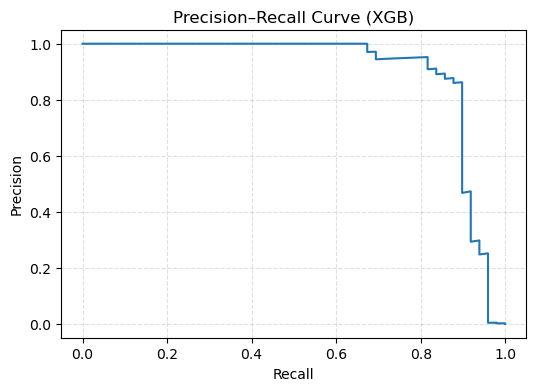

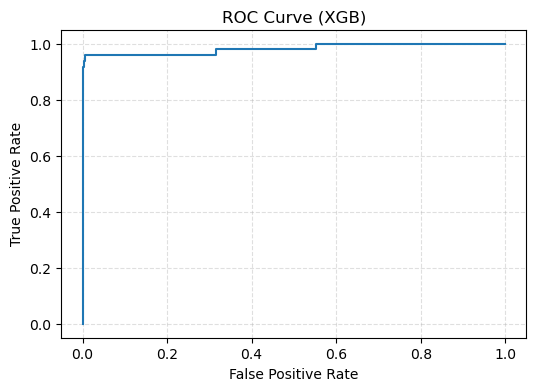

In [23]:
import boto3, io, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

REGION, BUCKET, PREFIX = "us-east-1", "udacity-fraud-capstone", "fraud"
s3 = boto3.client("s3", region_name=REGION)

# Load predictions from Batch Transform
resp = s3.list_objects_v2(Bucket=BUCKET, Prefix=f"{PREFIX}/batch-preds/")
keys = [o["Key"] for o in resp.get("Contents", []) if o["Key"].endswith(".out") or re.search(r"part-.*\\.csv$", o["Key"])]
pred_key = sorted(keys)[-1]
y_pred = pd.read_csv(io.BytesIO(s3.get_object(Bucket=BUCKET, Key=pred_key)["Body"].read()), header=None).iloc[:,0].to_numpy()

# Load true labels (first column = label)
y_true = pd.read_csv(io.BytesIO(s3.get_object(Bucket=BUCKET, Key=f"{PREFIX}/data/processed_xgb/test.csv")["Body"].read()), header=None).iloc[:,0].to_numpy()

# PR Curve
prec, rec, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve (XGB)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve (XGB)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [24]:
#Set vars
import sagemaker, boto3, io, pandas as pd
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer

REGION = "us-east-1"
ROLE   = "arn:aws:iam::911167919655:role/UdacityCapstone-SageMaker-ExecutionRole"
BUCKET = "udacity-fraud-capstone"
PREFIX = "fraud"

# Use the artifact you printed in B1 (paste if variable not in memory)
best_art = "s3://udacity-fraud-capstone/fraud/outputs/sagemaker-xgboost-250821-1000-002-593cfed0/output/model.tar.gz"
sess = sagemaker.Session()


In [25]:
#Deploy endpoint
container = retrieve("xgboost", REGION, version="1.7-1")

endpoint_name = "fraud-xgb-endpoint"  # change if this name already exists
model = Model(
    image_uri=container,
    model_data=best_art,
    role=ROLE,
    sagemaker_session=sess,
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name,
    serializer=CSVSerializer(),         # sends 'text/csv'
    deserializer=StringDeserializer()   # returns raw string
)
print("Live endpoint:", endpoint_name)



INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-08-21-10-45-45-129
INFO:sagemaker:Creating endpoint-config with name fraud-xgb-endpoint
INFO:sagemaker:Creating endpoint with name fraud-xgb-endpoint


------!Live endpoint: fraud-xgb-endpoint


In [28]:
#Verify endpoint status
import boto3
REGION = "us-east-1"
endpoint_name = "fraud-xgb-endpoint"

sm = boto3.client("sagemaker", region_name=REGION)
print(sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"])



InService


In [29]:
#Attach Endpoint

import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer

sess = sagemaker.Session()

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=CSVSerializer(),        # sends text/csv
    deserializer=StringDeserializer()  # gets plain string back
)
print("Predictor attached to:", predictor.endpoint_name)


Predictor attached to: fraud-xgb-endpoint


In [32]:
#Wrap predictor so it always returns probabilities
import numpy as np
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer

endpoint_name = "fraud-xgb-endpoint"

predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=CSVSerializer(),
    deserializer=StringDeserializer(),
)

def predict_proba_csv_line(csv_line: str) -> float:
    """Call endpoint and return P(fraud). If model returns margin, apply sigmoid."""
    raw = predictor.predict(csv_line)
    # Robust parse: pull first number
    import re
    m = re.search(r"[-+]?\d*\.\d+|\d+", raw)
    if not m:
        raise RuntimeError(f"Unexpected response: {raw!r}")
    x = float(m.group(0))
    # If outside [0,1], treat as log-odds margin and sigmoid it
    if x < 0.0 or x > 1.0:
        x = 1.0 / (1.0 + np.exp(-x))
    return float(x)


In [33]:
#Test a single row (should now be in [0,1])
import boto3, io, pandas as pd

REGION, BUCKET, PREFIX = "us-east-1", "udacity-fraud-capstone", "fraud"
s3 = boto3.client("s3", region_name=REGION)

obj = s3.get_object(Bucket=BUCKET, Key=f"{PREFIX}/data/processed_xgb/test_nolabel.csv")
sample = pd.read_csv(io.BytesIO(obj["Body"].read()), header=None).head(1)
payload = ",".join(map(str, sample.iloc[0].tolist()))
prob = predict_proba_csv_line(payload)
print({"probability_of_fraud": prob})



{'probability_of_fraud': 0.9681405084538391}


In [34]:
#Stratified mini-eval (ensure positives are included)
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np, pandas as pd, io

# Load labels + features
lab_obj  = s3.get_object(Bucket=BUCKET, Key=f"{PREFIX}/data/processed_xgb/test.csv")
feat_obj = s3.get_object(Bucket=BUCKET, Key=f"{PREFIX}/data/processed_xgb/test_nolabel.csv")
y_true_full = pd.read_csv(io.BytesIO(lab_obj["Body"].read()), header=None).iloc[:,0].to_numpy()
X_full      = pd.read_csv(io.BytesIO(feat_obj["Body"].read()), header=None)

# Pick a stratified sample (up to 100 positives + 300 negatives, adjust if fewer)
pos_idx = np.where(y_true_full == 1)[0]
neg_idx = np.where(y_true_full == 0)[0]
n_pos = min(100, len(pos_idx))
n_neg = min(300, len(neg_idx))

sel = np.concatenate([np.random.choice(pos_idx, n_pos, replace=False),
                      np.random.choice(neg_idx, n_neg, replace=False)])
np.random.shuffle(sel)

# Predict via endpoint (with margin→prob fix)
probs = []
for i in sel:
    line = ",".join(map(str, X_full.iloc[i].tolist()))
    probs.append(predict_proba_csv_line(line))
probs = np.array(probs)
y_true = y_true_full[sel]

# Evaluate at your current operating threshold (start with 0.5)
TH = 0.5
y_hat = (probs >= TH).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary")

print({
  "N": int(len(sel)), "threshold": TH,
  "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
  "precision": float(prec), "recall": float(rec), "f1": float(f1)
})


{'N': 349, 'threshold': 0.5, 'tp': 45, 'fp': 288, 'tn': 12, 'fn': 4, 'precision': 0.13513513513513514, 'recall': 0.9183673469387755, 'f1': 0.2356020942408377}


In [35]:
#Auto-pick a better threshold for the endpoint
from sklearn.metrics import precision_recall_curve

# Load the batch-transform predictions & labels
bt_obj = s3.get_object(Bucket=BUCKET, Key=f"{PREFIX}/batch-preds/test_nolabel.csv.out")
y_pred_bt = pd.read_csv(io.BytesIO(bt_obj["Body"].read()), header=None).iloc[:,0].to_numpy()
y_true_bt = y_true_full  # labels already loaded above (first column of test_xgb)

prec, rec, ths = precision_recall_curve(y_true_bt, y_pred_bt)
# Maximize F1
f1 = (2*prec*rec) / (prec+rec + 1e-12)
best_i = f1.argmax()
TH_opt = float(ths[best_i]) if best_i < len(ths) else 0.5
print({"chosen_threshold": TH_opt, "precision": float(prec[best_i]), "recall": float(rec[best_i]), "f1": float(f1[best_i])})

# Re-evaluate the endpoint on the same stratified sample with TH_opt
y_hat2 = (probs >= TH_opt).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_hat2).ravel()
prec2, rec2, f12, _ = precision_recall_fscore_support(y_true, y_hat2, average="binary")
print({
  "endpoint_eval_with_opt_threshold": {
    "threshold": TH_opt,
    "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
    "precision": float(prec2), "recall": float(rec2), "f1": float(f12)
  }
})


{'chosen_threshold': 0.3861571252346039, 'precision': 0.8627450980392157, 'recall': 0.8979591836734694, 'f1': 0.8799999999995001}
{'endpoint_eval_with_opt_threshold': {'threshold': 0.3861571252346039, 'tp': 46, 'fp': 288, 'tn': 12, 'fn': 3, 'precision': 0.1377245508982036, 'recall': 0.9387755102040817, 'f1': 0.2402088772845953}}
